In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import openpyxl
import pycountry
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

model designed for nfl
https://fivethirtyeight.com/methodology/how-our-nfl-predictions-work/

# Goal

The goal of this program is to build an ELO scoring system for international rugby. The first is to develop the model with optimal parameters that will work for game prediction. A second step is to adapt it to work in game.

# Step 1 : Import and clean the data

In [3]:
current_dir = os.getcwd()

folder = "/data/results_international/"
result_file = 'scrap_out.xlsx'
result_url = current_dir+folder+result_file

In [4]:
#def analyse_rating_system()

def analyse_data(df):
    Score_array = np.concatenate((df["Score A"].values, (df["Score B"].values)))
    score_fre_ax = plt.hist(Score_array, bins=50)
    plt.title("Scores Frequency")
    plt.show()
    
def result_table_site(url):
    df = pd.read_csv(url)
    df.drop(columns=['world_cup'], inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    #f = df.rename(columns={'Date': 'date', 'home_team' : 'Team A', 'away_team':'Team B', 'home_score' : 'Score A', 'away_score':'Score B', 'competition':'Tourn', 'stadium':'Venue', 'city':'City', 'country': 'Country', 'neutral': 'Neut.'})
    return df
    
def rugby_df_creator(url):  
    raw_result_df = pd.read_excel(url,  index_col=0)
    #raw_result_df = raw_result_df.rename(columns={'Date':'date'})
    raw_result_df['Date'] = pd.to_datetime(raw_result_df['Date'])
    #than we will deal with some missing value
    #Na in neutral = False
    #raw_result_df['Neut.'].fillna(False, inplace=True)
    #set missing tournament to Friendly
    raw_result_df['Tourn'].fillna("Friendly", inplace=True)
    #raw_result_df.sort_values(by=['Date'], inplace=True)
    return raw_result_df

def final_df_creator(df, first_year=1882):
    df = df[df['date'].dt.year >= first_year].reset_index(drop=True)
    return df 

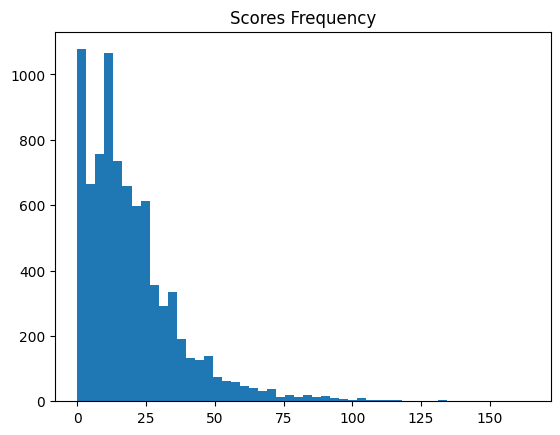

In [5]:
result_df = rugby_df_creator(result_url)
analyse_data(result_df)

# Step 2: Initializing the Scoring System

In [6]:
# define the function to compute the new rating,
# cc is the correlation coefficient => used to deal with autocorrelation 
# mc the margin coefficient, use to cap the change in score on a log scale
#k is
# W is the point for a win -set to 1
#Ws is the probability of a win
# K is a factor that regulates how quickly the rating changes in response to new information -> high means recents games have a big effect
#set to 20 in the nfl

#factor that takes into account the point difference, also take care of autocorrelation => a good team wins more often but also 
# give more blowouts.

def movMultiplier(home_point, away_point, home_rating, away_rating):
    coeff = np.log(abs(home_point-away_point)+1)*(2.2/(abs(home_rating-away_rating)*0.001+2.2))
    return coeff

def corr_coef(winner_rating, looser_rating):
    return 2.2/((winner_rating-looser_rating)*0.001+2.2)
 
#takes into account how the team wins=> test multiples
def margin_coeff(home_point, away_point):
    return (log(abs(home_point -away_point))+1)
            
#the win expectancy, adifference of rating plus a home field advantage constant
def proba_win(home_rating, away_rating):
    proba = 1/(1+10**(-(home_rating-away_rating)/400))
    return proba
            
def elo_adj(home_rating, away_rating, score_home, score_away, K):
    W= 1
    if score_home<score_away:
        W=0
    elif score_home==score_away:
        W=0.5
    return movMultiplier(score_home, score_away, home_rating, away_rating)*(W-proba_win(home_rating, away_rating))*K

def analyse_results(elo_dict):
    #input: a dict with an empty dict where keys are the possible countries
    #output: a df with final elo rating
    #function display a graph of the final results
    elo_df = pd.DataFrame.from_dict(elo_dict, orient='index').reset_index().rename(columns={'index' :"countrie", 0:"score"})
    elo_df.sort_values("score", inplace=True)
    plt.figure(figsize=(30,20))
    plot = plt.barh(elo_df.countrie, width=elo_df.score)
    plt.title("Final Elo Rating 2023")
    plt.xticks(rotation=90)
    plt.show()
    return elo_df
def update_elo(row, teams_elo,  K=29, home_adj=0):
    #inputs: a row of the result df, a coefficient factor K, the score adjustement for home team
    #output: a row with the elo of the home team, elo of away team and proba of winning added.
    #function: will we use to update resutl df. main function
    
    row['elo_home'] =  teams_elo[f"{row['Team A']}"]
    row['elo_away'] =  teams_elo[f"{row['Team B']}"]
    
    if row['Neut.'] == True:
     
        row['proba_home_win'] = proba_win(row['elo_home'], row['elo_away'])
    else:
        #Add a number of point to ajust for home advantage
        row['proba_home_win'] = proba_win((row['elo_home']+home_adj), row['elo_away'])
    
    adj = elo_adj(teams_elo[f"{row['Team A']}"], teams_elo[f"{row['Team B']}"], row['Score A'],row['Score B'], K)
    
   
    row['elo_gap'] = row['elo_home'] - row['elo_away']
    row['outcome'] = 1 if (row['Score A']>row['Score B']) else (0.5 if (row['Score A'] ==row['Score B']) else 0)
    teams_elo[f"{row['Team A']}"] += adj
    teams_elo[f"{row['Team B']}"] -= adj 
   
    return row


def elor_generator(result_df, starting_elo=1000, K=31, home_adjust=0):
    #inputs: the inital df with match results, updated
    #outputs: returns a df with the fixture results, as well as a dict with the final elo
    #function take the url_file, create a df with the result, create the dict with the elo rating from all the data
    teams_elo = {}
    home_list = list(result_df['Team A'].unique())
    away_list = list(result_df['Team B'].unique())
    home_list.extend(away_list)
    #initialize a dict of teams:
    for team in home_list:
        teams_elo[team]= starting_elo
    
    result_df = result_df.apply(lambda row :update_elo(row, teams_elo, K, home_adjust), axis=1)
        
    return  result_df, teams_elo

### Testint the elo adj Function
We will ensure that the value increases with the gap in scoring and elo

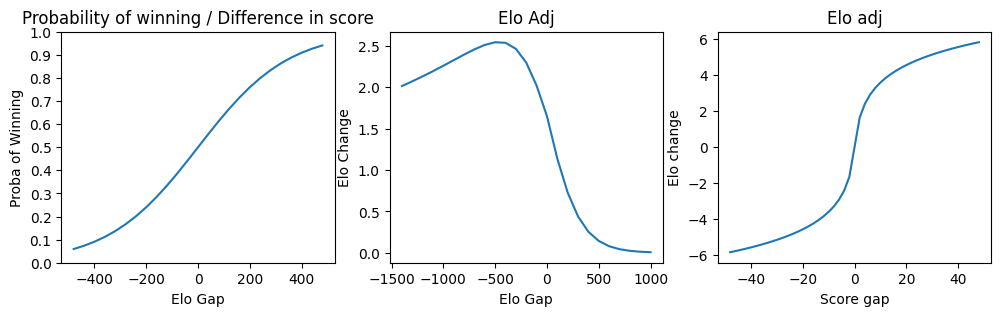

In [7]:
plt.figure(figsize=(12, 3))

elo_gaps = [40*x for x in range(-12, 13)]
proba = [proba_win(1000, 1000-gap) for gap in elo_gaps]
plt.subplot(131)
plt.plot(elo_gaps, proba)
plt.title('Probability of winning / Difference in score')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xlabel("Elo Gap")
plt.ylabel("Proba of Winning")


elo_a = 1000
elo_b = [100*x for x in range(0,25)]
elo_gap = [elo_a-b for b in elo_b]
#check with a identical score
elo_test_a = [elo_adj(elo_a, variable, 12, 10, 3) for variable in elo_b ]
plt.subplot(132)
plt.plot(elo_gap ,elo_test_a )
plt.title("Elo Adj")
plt.xlabel("Elo Gap")
plt.ylabel("Elo Change")


#check for different score
score_a = 50
score_b = [2*x for x in range(1,50)]
score_gap = [score_a-b for b in score_b]
elo_test_b= [elo_adj(1000, 1000, score_a, variable, 3) for variable in score_b ]
plt.subplot(133)
plt.plot(score_gap ,elo_test_b )
plt.title("Elo adj")
plt.xlabel("Score gap")
plt.ylabel("Elo change")
plt.show()

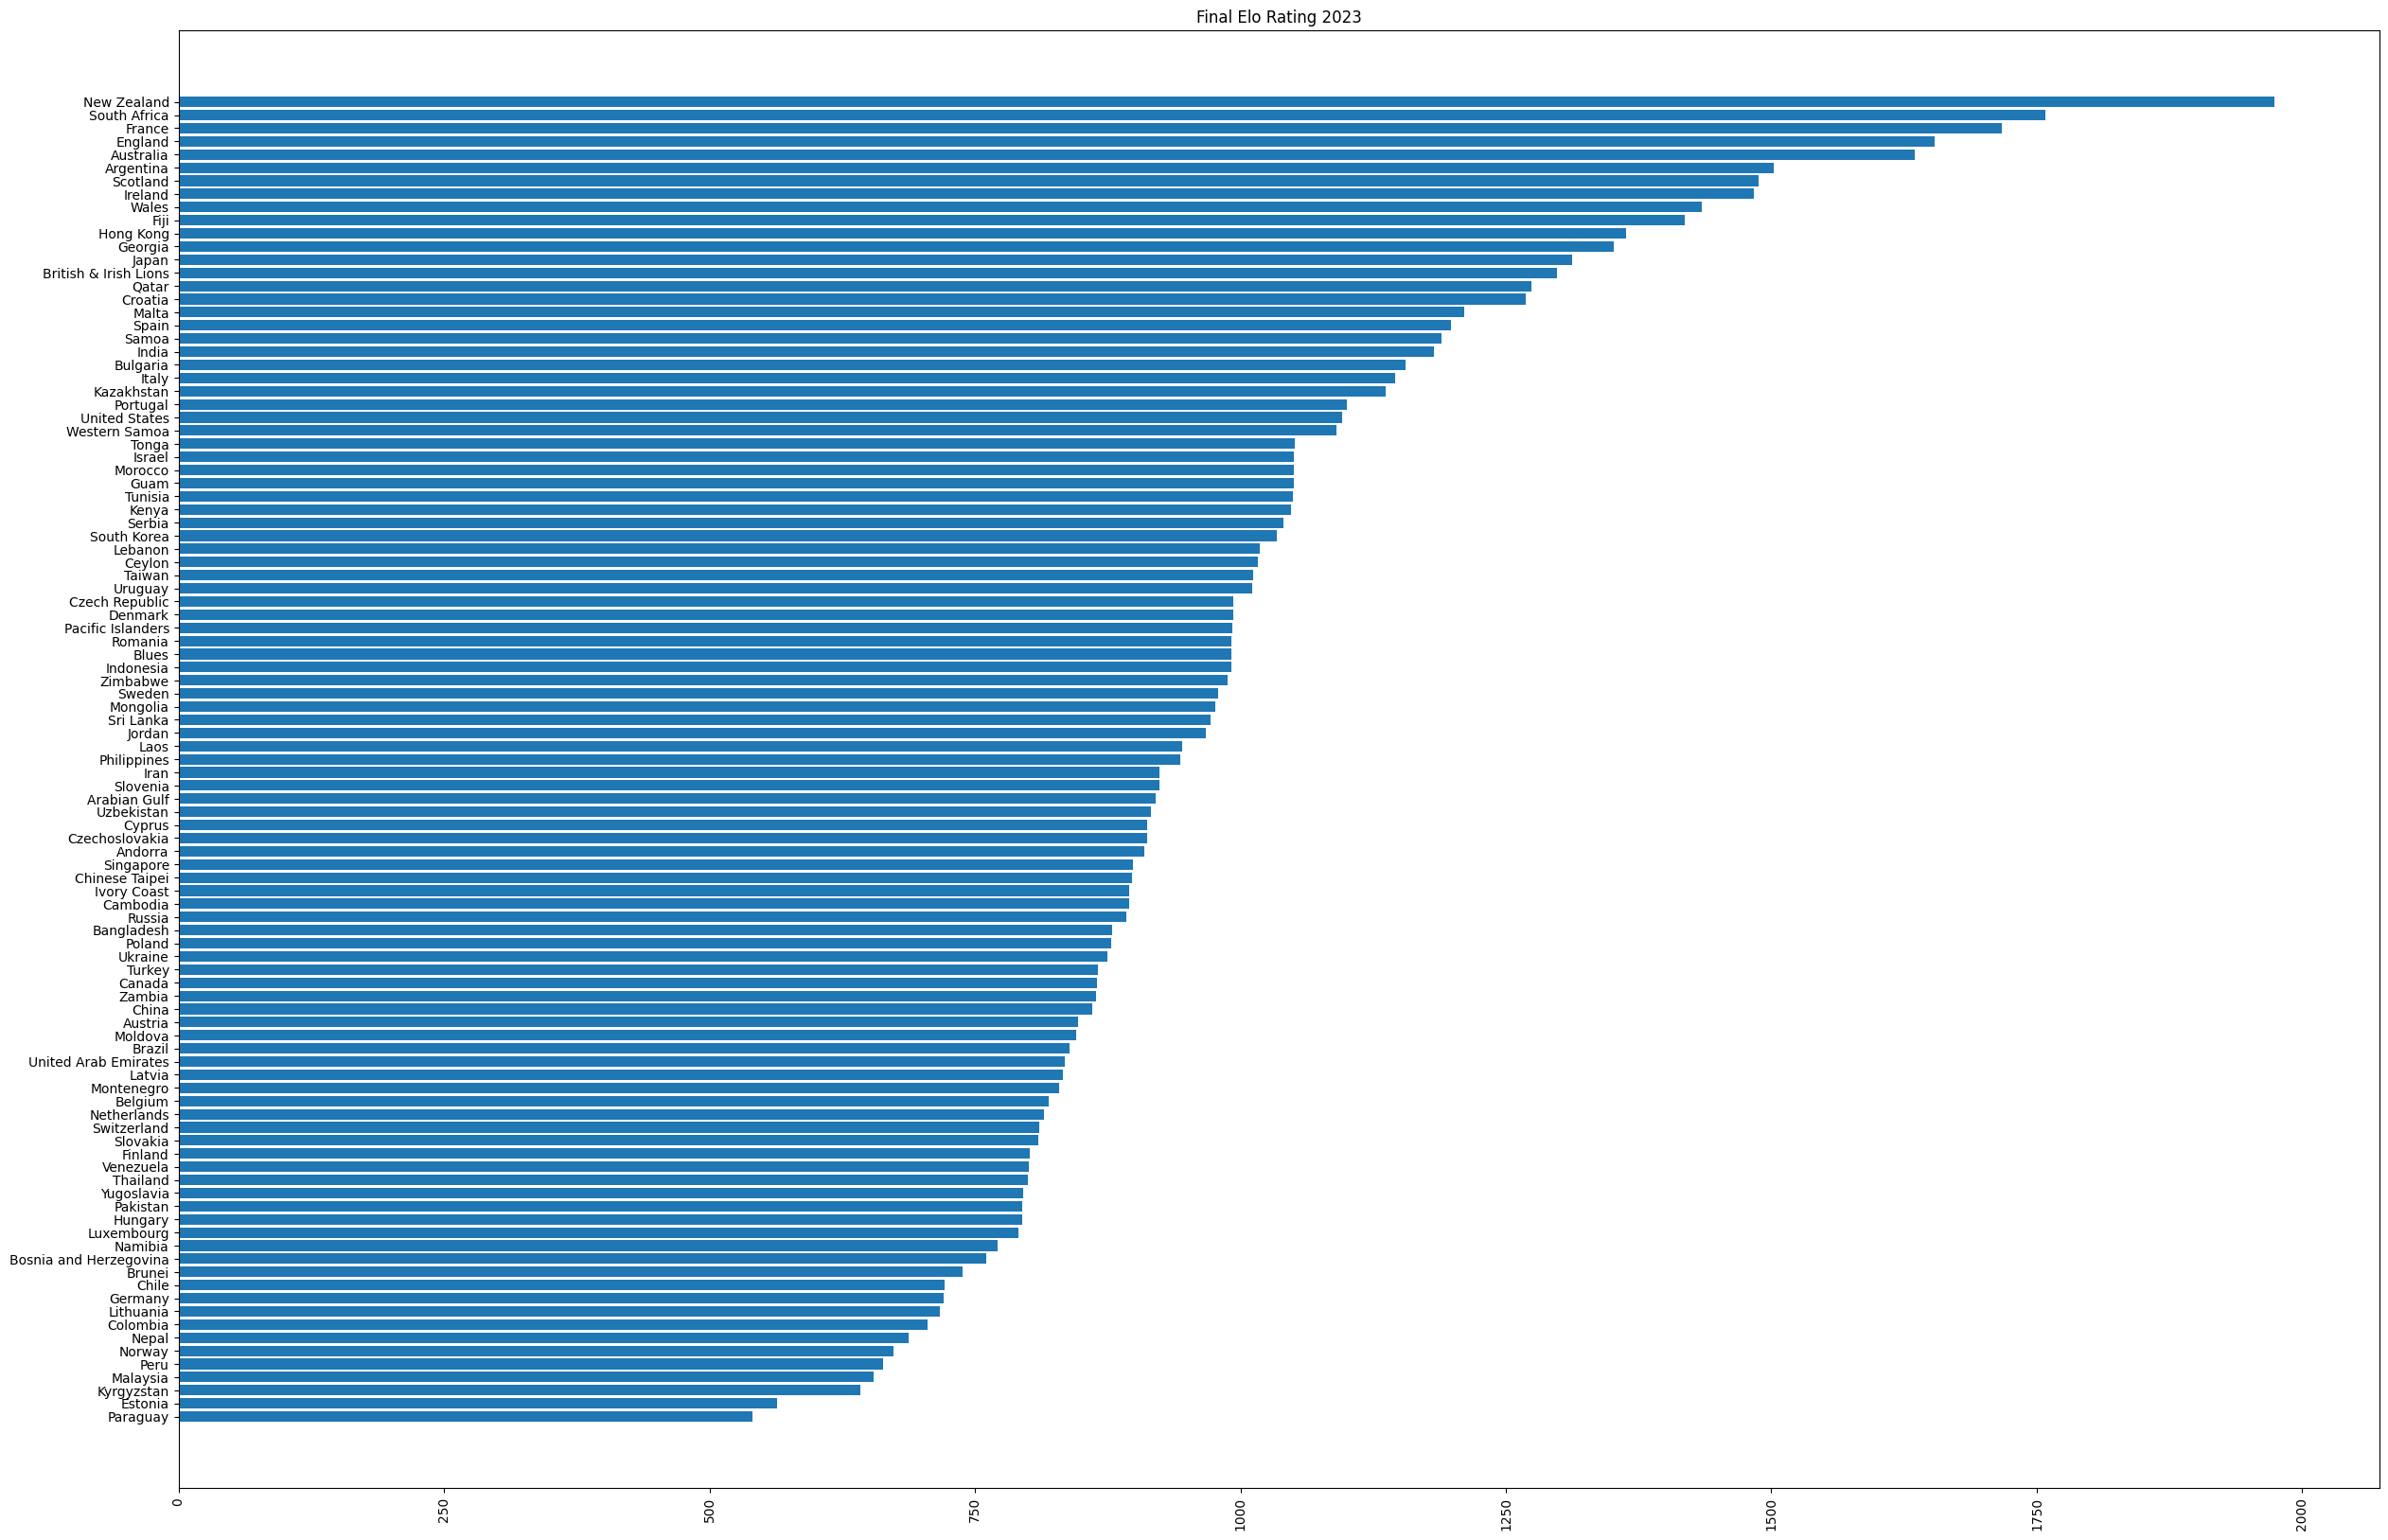

In [8]:
final_result_df, elo_dict = elor_generator(result_df,1000)
elo_df = analyse_results(elo_dict)

### Evaluate new team average performance

All team were not present right from the start, the question is how many point should be alocated to a new time ? we will take the average of their performance 

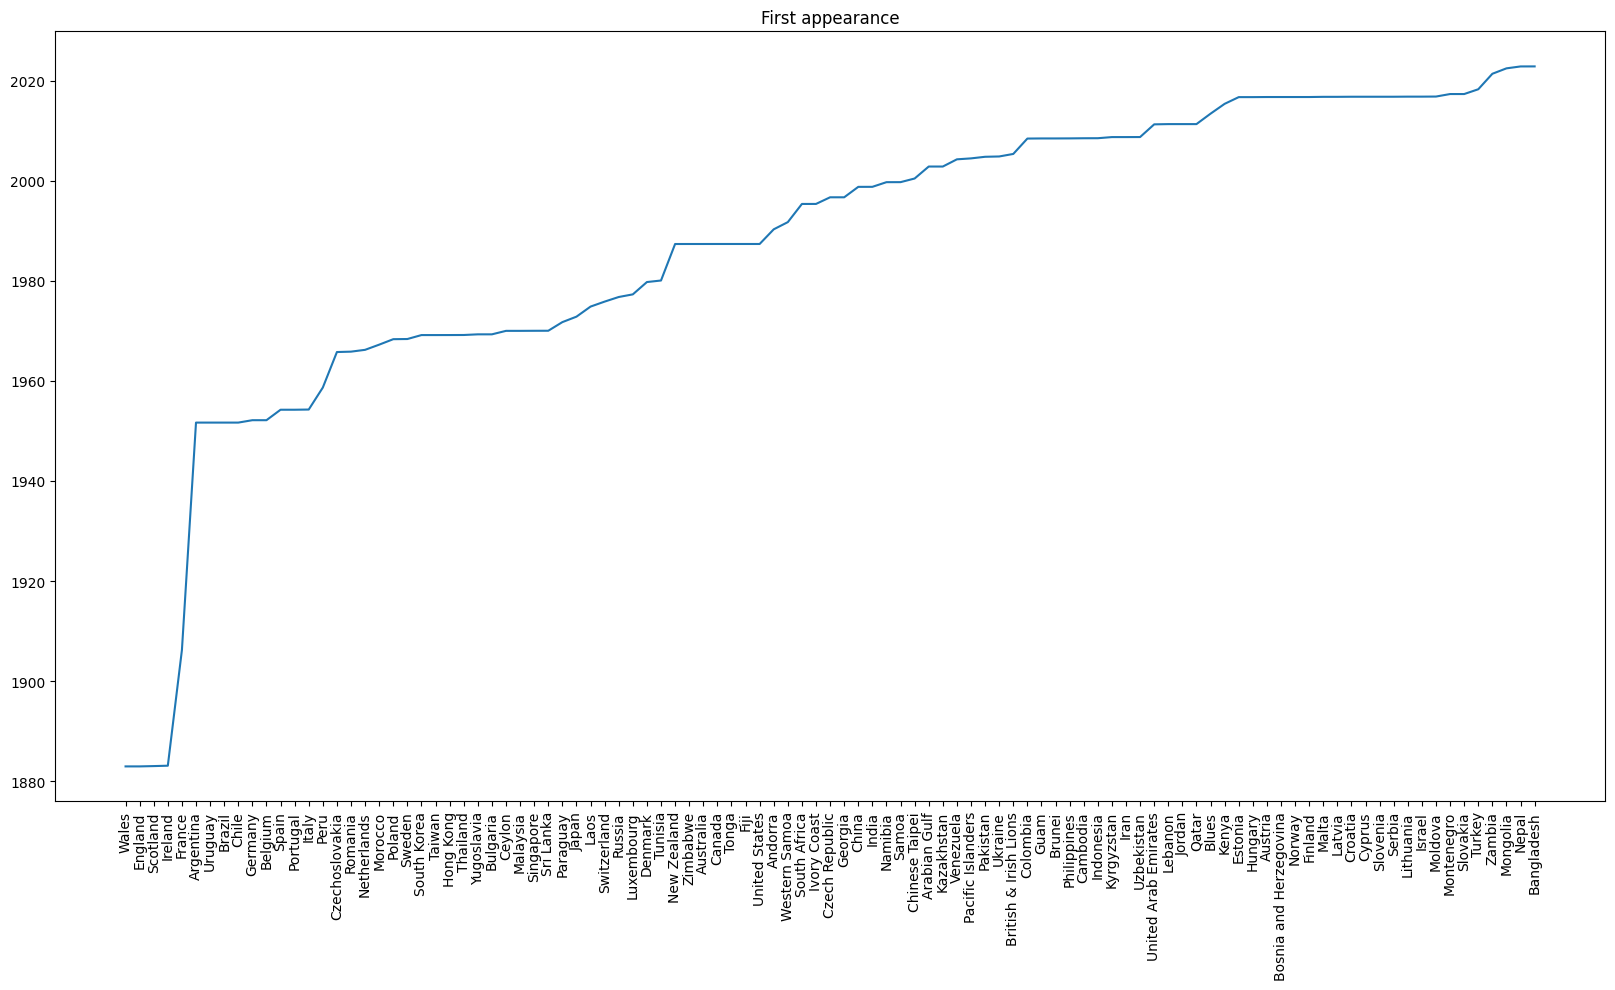

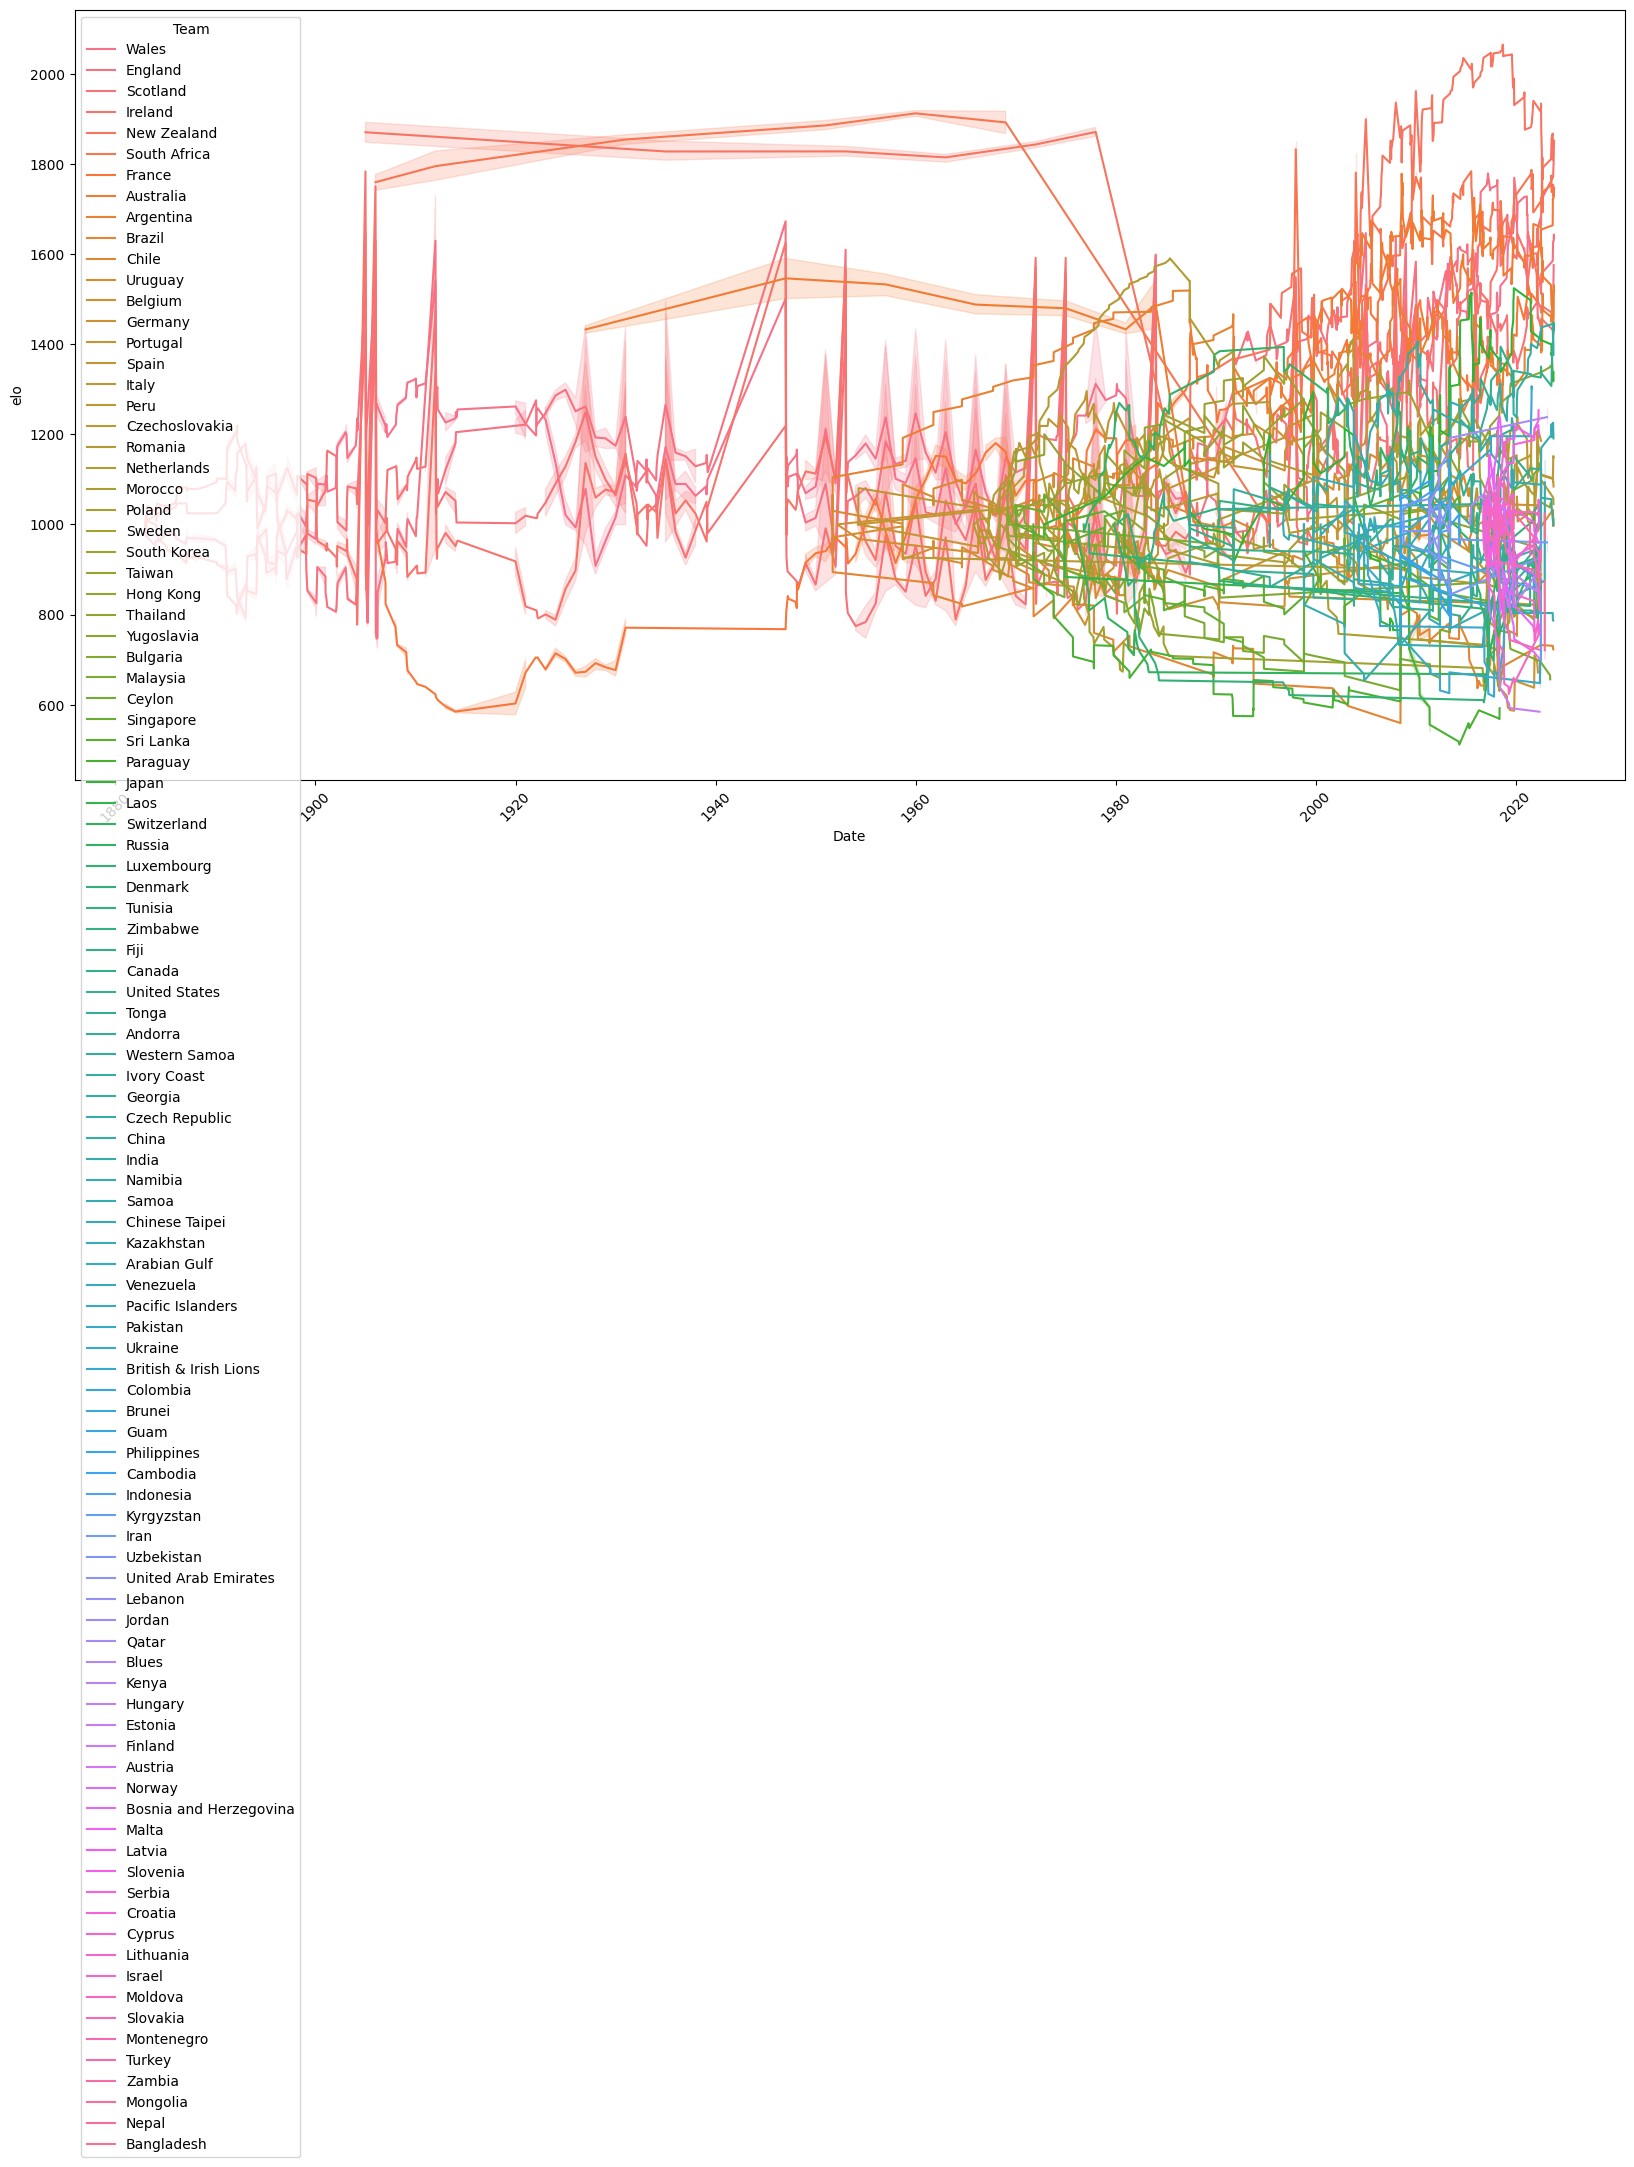

In [9]:
#find when each team appearf for the first time
viewed = []
date = []

def lookout_team(row, viewed, date):
    if row['Team A'] not in viewed:
        viewed.append(row['Team A'])
        date.append(row['Date'])
    if row['Team B'] not in viewed:
        viewed.append(row['Team B'])
        date.append(row['Date'])
    return row

def split_df(df):
    #input: the df with proba and elo
    #output: a df where each row has the variable for one team
    #function: will be use to compute mean perf
    team_a_df = df[['Date', 'Team A', 'Score A','elo_home', 'Tourn', 'Venue', 'City', 'Neut.', 'Country', 'outcome']].rename(columns={'Team A': 'Team', 'Score A': 'Score', 'elo_home':'elo'})
    team_b_df = df[['Date', 'Team B', 'Score B', 'elo_away','Tourn', 'Venue', 'City', 'Neut.', 'Country', 'outcome']].rename(columns={'Team B': 'Team', 'Score B': 'Score', 'elo_away':'elo'})
    result = pd.concat([team_a_df, team_b_df]).sort_values(by='Date').reset_index(drop=True)
    return result
    
def mean_performance(countries, df, year=1880):
    #input: a list of unique country and the df split with plit-df
    #output: a list of average elo perfoamnces
    #function: use to selectec value to attribute to new countries
    performance = []
    for count in countries:
        performance .append(df[(df['Team']==count) & (df['Date'].dt.year>year)]['elo'].mean())
    return performance
#def mean_perf_new_entry(country, first_app, df):
split_df = split_df(final_result_df)

result_df = result_df.apply((lambda row : lookout_team(row, viewed, date)), axis=1)
mean_perf =  mean_performance(viewed, split_df)

plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
plt.plot(viewed, date)
plt.title('First appearance')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
sns.lineplot(data = split_df, x='Date', y='elo',hue='Team')
#plt.title('First appearance')
#plt.xticks(rotation=90)
plt.show()

## Evaluate the model

### The accuracy of prediciton

In [10]:
#the brier score will be use to evaluate the model, the lower the better
def brier_score(ws, w):
    brier_score_sum = 0
    for event in range(len(ws)):
        brier_score_sum += (ws.iloc[event] - w.iloc[event]) ** 2
    return (brier_score_sum / len(ws))
    

In [11]:
score = brier_score(final_result_df['proba_home_win'],final_result_df['outcome'])
print(score)

0.1877892455178063


# test multipe k


In [12]:
ks = [k for k in range(1,32,2)]
scores = []

for i in ks:
    result_df, elo_dict = elor_generator(result_df,1000, i)
    scores.append(brier_score(result_df['proba_home_win'],result_df['outcome']))
print(scores)

[0.22521861176184016, 0.21171972466637248, 0.2048069743517922, 0.20038743009386636, 0.19727423199168903, 0.19496190372408187, 0.19319416958564792, 0.191817200340526, 0.19074085037181635, 0.18989522359185318, 0.18923668007760214, 0.188731769328335, 0.18835319584125307, 0.18807980293875154, 0.18789611202896517, 0.1877892455178063]


[0.22521861176184016, 0.21171972466637248, 0.2048069743517922, 0.20038743009386636, 0.19727423199168903, 0.19496190372408187, 0.19319416958564792, 0.191817200340526, 0.19074085037181635, 0.18989522359185318, 0.18923668007760214, 0.188731769328335, 0.18835319584125307, 0.18807980293875154, 0.18789611202896517, 0.1877892455178063]


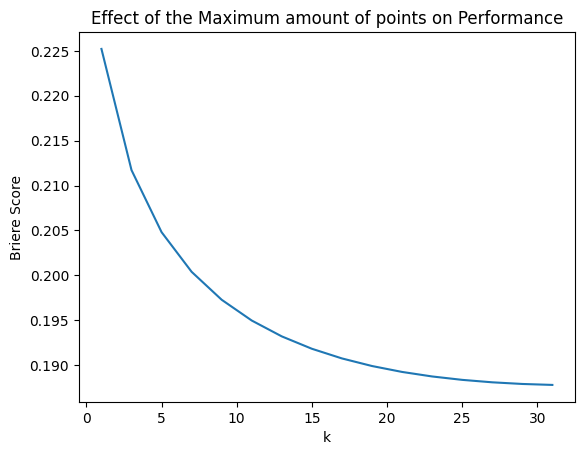

Best K=31


In [13]:
print(scores)
plt.plot(ks, scores)
plt.title('Effect of the Maximum amount of points on Performance')
plt.xlabel('k')
plt.ylabel('Briere Score')
plt.show()

best_k = ks[scores.index(min(scores))]
print(f'Best K={best_k}')

### Do the win probability distribution matches the actual results?

In [14]:
# here we will round up to 2 digits the proba of wining, and check the outcome for each probab.
result_df, elo_dict = elor_generator(result_df,1000, best_k)
proba_df = result_df.loc[pd.to_datetime(result_df['date']).dt.year > 2000]
proba_df["proba_home_win"] = proba_df["proba_home_win"].round(decimals=2)
proba_df["elo_gap"] = proba_df["elo_gap"].round(decimals=0)
proba_df.head()

KeyError: 'date'

In [ ]:
#here need to define a number of gaps, 

observrd_proba = []
gap = []
step = 100
i = proba_df["elo_gap"].min()

while i <= proba_df["elo_gap"].max():
    selected = proba_df.loc[(proba_df["elo_gap"]>=i) & (proba_df["elo_gap"]< i+step)]
    try:
        proba = selected[(selected["Score A"]) >(selected["Score B"])].shape[0] / selected.shape[0]
        observrd_proba.append(proba)
        gap.append(i)
    except ZeroDivisionError:
        print(f"Nothing for gaps between {i} and {i+step}")
    i += step

print(len(observrd_proba))
print(len(gap))
plt.plot(gap, observrd_proba)
plt.title('Observed Proba of wining Per ELo Gap')
plt.xlabel("Elo Gap")
plt.ylabel("Probability of winning")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.show()

## Working out the home-filed adjustment
a boost in elo given to the home team, take into account the distance?

In [ ]:
#first step is to compare the difference in winrate between expexted win proba and the real win proba at home, if there is a difference, adjust elo of home team acordingly
#this a source with similar odd discovers
'https://www.chicagobooth.edu/review/home-field-advantage-facts-and-fiction#:~:text=International%20cricket%20teams%20win%2060.1,win%2054.1%25%20of%20the%20time.'

def gap_from_proba(proba):
    return (-400*np.log10((1-proba)/proba))

#result_df, elo_dict = elor_generator(result_url,1000, best_k)
#make sure to not take into account the neutral grounds
home_adv_proba = np.mean(result_df[result_df['Neut.']!='Y'].outcome) - 0.5
home_adj_elo = gap_from_proba(0.6)
print(f'The home team wins {home_adv_proba} more, equivalent to an elo gap of {home_adj_elo }')
#We then work back from the proba function to find the gap in elo giving this odd. We will do some test to find the best 

In [ ]:
adj_to_test = [0,10,25,50, 60,65,70,75,80]
adj_scores = []

for i in range(len(adj_to_test)):
    result_df_home_adj, elo_dict_home_adj = elor_generator(merged_df,1000, adj_to_test[i])
    int_score = brier_score(result_df_home_adj['proba_home_win'],result_df_home_adj['outcome'])
    adj_scores.append(int_score)

plt.plot(adj_to_test, adj_scores)
plt.title('Effect of Home Game Adjustment')
plt.xlabel = 'Elo Advantage Home Team'
plt.ylabel = 'Briere Score'
plt.show()

best_adj_to_test = adj_to_test[adj_scores .index(min(adj_scores ))]
print(f'The best adj is + {best_adj_to_test}')

In [ ]:
print(f'The best adj is + {best_adj_to_test}')

In [ ]:
#is is better than before?
score_home_adj = brier_score(result_df_home_adj['proba_home_win'],result_df_home_adj['outcome'])
print(score_home_adj)

In [ ]:
#save the file
result_df.to_csv(current_dir+folder+'adj_final_results.csv')

## Working out an adjustement if the team is rested
look at if rest gives a disavantage, days between games

## Working out an adjustement for competitive games

## Working out if weather improves prediction

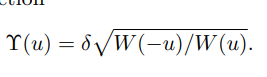